# XG-Boost

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
lasso_features = ['admissionheight', 'admissionweight', 'dischargeweight' ,
                  'icuduration', 'weightdiffafterdischarge', 'intubated', 
                  'vent', 'dialysis', 'urine', 'wbc', 'temperature',
                  'respiratoryrate', 'sodium', 'heartrate', 'meanbp', 
                  'creatinine', 'glucose', 'bun', 'meanapachescore',
                  'meanpredictedicumortality', 'meanpredictediculos',
                  'immunosuppression', 'diabetes', 'teachingstatus', 
                  'minnoninvasivesystolic', 'meannoninvasivesystolic', 
                  'maxnoninvasivesystolic', 'minnoninvasivediastolic', 
                  'meannoninvasivediastolic', 'maxnoninvasivediastolic', 
                  'noninvasivemeanmin', 'noninvasivemeanavg', 
                  'noninvasivemeanmax', 'age0-9', 'age10-19', 'age20-29',
                  'age30-39', 'age40-49', 'age50-59', 'age60-69', 'age>89', 
                  'gendermale', 'ethnicity_African American', 'ethnicity_Asian',
                  'ethnicity_Caucasian', 'ethnicity_Hispanic', 
                  'ethnicity_Native American', 'ethnicity_Other/Unknown',
                  'hospitaladmitsource_Acute Care/Floor', 
                  'hospitaladmitsource_Chest Pain Center', 
                  'hospitaladmitsource_Direct Admit', 
                  'hospitaladmitsource_Emergency Department', 
                  'hospitaladmitsource_Floor', 'hospitaladmitsource_ICU', 
                  'hospitaladmitsource_ICU to SDU', 
                  'hospitaladmitsource_Observation', 
                  'hospitaladmitsource_Operating Room', 
                  'hospitaladmitsource_Other Hospital', 
                  'hospitaladmitsource_Other ICU', 
                  'hospitaladmitsource_Step-Down Unit (SDU)', 
                  'unittype_CCU-CTICU', 'unittype_CSICU', 'unittype_CTICU', 
                  'unittype_Cardiac ICU', 'unittype_MICU', 
                  'unittype_Med-Surg ICU', 'unittype_Neuro ICU', 
                  'unitadmitsource_Acute Care/Floor', 
                  'unitadmitsource_Chest Pain Center', 
                  'unitadmitsource_Direct Admit', 
                  'unitadmitsource_Emergency Department', 
                  'unitadmitsource_Floor', 'unitadmitsource_ICU',
                  'unitadmitsource_ICU to SDU', 'unitadmitsource_Observation',
                  'unitadmitsource_Operating Room', 
                  'unitadmitsource_Other Hospital', 'unitadmitsource_Other ICU',
                  'unitadmitsource_PACU', 'unitadmitsource_Recovery Room', 
                  'unitadmitsource_Step-Down Unit (SDU)', 
                  'numbedscategory_100 - 249', 'numbedscategory_250 - 499',
                  'numbedscategory_<100', 'numbedscategory_>= 500', 
                  'hospitalregion_Midwest', 'hospitalregion_South', 
                  'dischargehour8-14']

In [3]:
# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X_train = train.loc[:, lasso_features]
X_test = test.loc[:, lasso_features]
y_train = train.died
y_test = test.died

In [4]:
# XG-Boost doesn't accept characters such as <, > in feature names
X_train.rename(columns={'numbedscategory_<100': 'numbedscategory_lt_100', 
                        'numbedscategory_>= 500': 'numbedscategory_gte_500'}, 
               inplace=True)
X_test.rename(columns={'numbedscategory_<100': 'numbedscategory_lt_100', 
                       'numbedscategory_>= 500': 'numbedscategory_gte_500'}, 
              inplace=True)

### Train baseline XG-Boost with default parameters

In [5]:
xgb_mod = xgb.XGBClassifier(random_state=670)
xgb_mod.fit(X_train, y_train)
train_auc = roc_auc_score(y_train, xgb_mod.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, xgb_mod.predict_proba(X_test)[:, 1])

print(round(train_auc, 3))
print(round(test_auc, 3))

1.0
0.829


In [8]:
# Set up k-fold validation set
k_folds = KFold(n_splits=5, shuffle=True, random_state=670)
splits = list(k_folds.split(X_train, y_train))

In [33]:
param_grid = {'n_estimators': range(100, 600, 100),
              'learning_rate': [0.001, 0.01, 0.1, 1],
              'max_depth': [2, 4, 6, 8]}

grid_search = GridSearchCV(estimator=xgb_mod,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=splits,
                           n_jobs=-1)
grid_search.fit(X_train, y_train) 

# Get best parameters from Grid Search
print(grid_search.best_params_)

train_auc = grid_search.score(X_train, y_train)
test_auc = grid_search.score(X_test, y_test)

print(round(train_auc, 3))
print(round(test_auc, 3))

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500}
0.917
0.855


In [15]:
def plot_validation_curves(model, param_range, data, target, param_name, 
                           scoring, cv, ylabel):
    
    train_scores, valid_scores = validation_curve(model, 
                                                  data, 
                                                  target, 
                                                  param_name=param_name, 
                                                  param_range=param_range,
                                                  scoring=scoring,
                                                  cv=cv)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    
    plt.title(f'Validation Curve with {param_name}')
    plt.xlabel(f'{param_name}')
    plt.ylabel(ylabel)
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(
        param_range, 
        train_scores_mean, 
        label="Training score", 
        color="darkorange", 
        lw=lw
    )
    plt.fill_between(
        param_range,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.2,
        color="darkorange",
        lw=lw,
    )
    plt.plot(
        param_range, 
        valid_scores_mean, 
        label="Cross-validation score", 
        color="navy", 
        lw=lw
    )
    plt.fill_between(
        param_range,
        valid_scores_mean - valid_scores_std,
        valid_scores_mean + valid_scores_std,
        alpha=0.2,
        color="navy",
        lw=lw,
    )
    plt.legend(loc="best")
    plt.show()

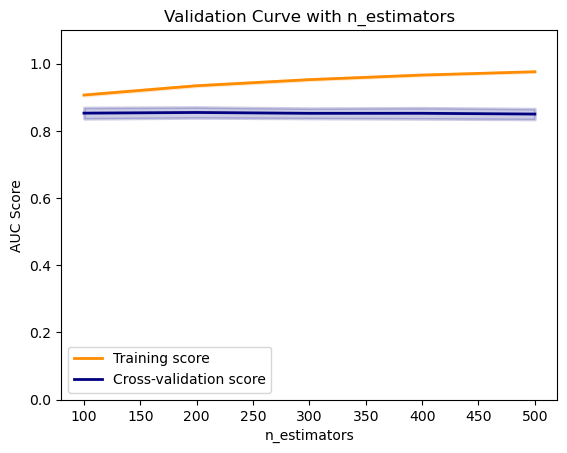

In [17]:
# Plot validation curves for n_estimators
plot_validation_curves(model=xgb_mod, 
                       param_range=range(100, 600, 100), 
                       data=X_train, 
                       target=y_train, 
                       param_name='n_estimators', 
                       scoring='roc_auc', 
                       cv=splits, 
                       ylabel='AUC Score')

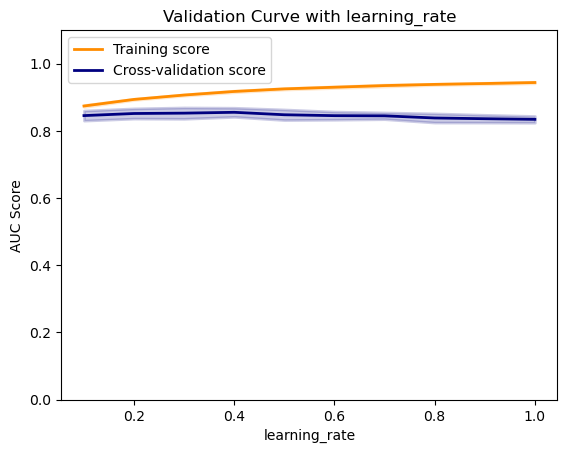

In [23]:
# Plot validation curves for learning rate
plot_validation_curves(model=xgb_mod, 
                       param_range=np.arange(0.1, 1.1, 0.1), 
                       data=X_train, 
                       target=y_train, 
                       param_name='learning_rate', 
                       scoring='roc_auc', 
                       cv=splits, 
                       ylabel='AUC Score')

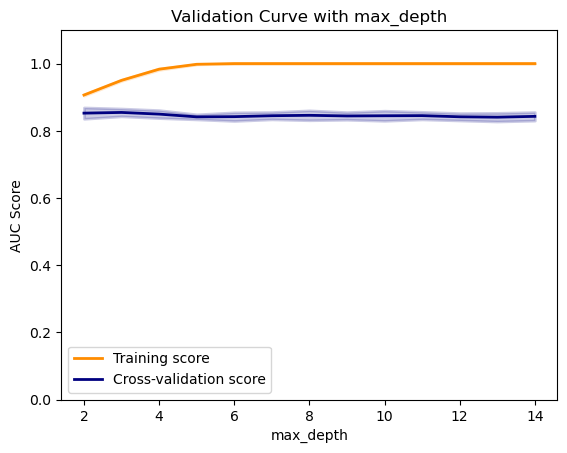

In [24]:
# Plot validation curves for max depth
plot_validation_curves(model=xgb_mod, 
                       param_range=range(2, 15, 1), 
                       data=X_train, 
                       target=y_train, 
                       param_name='max_depth', 
                       scoring='roc_auc', 
                       cv=splits, 
                       ylabel='AUC Score')

In [12]:
param_grid_2 = {'n_estimators': [400, 500, 600],
                'learning_rate': [0.05, 0.1, 0.15]}

grid_search_2 = GridSearchCV(estimator=xgb.XGBClassifier(max_depth=2,
                                                         random_state=670),
                             param_grid=param_grid_2,
                             scoring='roc_auc',
                             cv=splits,
                             n_jobs=-1)
grid_search_2.fit(X_train, y_train) 

# Get best parameters from Grid Search
print(grid_search_2.best_params_)

train_auc = grid_search_2.score(X_train, y_train)
test_auc = grid_search_2.score(X_test, y_test)

print(round(train_auc, 3))
print(round(test_auc, 3))

{'learning_rate': 0.15, 'n_estimators': 400}
0.924
0.853


In [28]:
xgb_mod_2 = xgb.XGBClassifier(learning_rate=0.1, 
                              max_depth=2, 
                              n_estimators=500,
                              random_state=670)

param_grid_3 = {'colsample_bytree': [0.1, 0.3, 0.5, 0.7],
                'subsample': [0.1, 0.3, 0.5, 0.7],
                'scale_pos_weight': [1, 3, 5, 7]}

grid_search_3 = GridSearchCV(estimator=xgb_mod_2,
                             param_grid=param_grid_3,
                             scoring='roc_auc',
                             cv=splits,
                             n_jobs=-1)
grid_search_3.fit(X_train, y_train) 

# Get best parameters from Grid Search
print(grid_search_3.best_params_)

train_auc = grid_search_3.score(X_train, y_train)
test_auc = grid_search_3.score(X_test, y_test)

print(round(train_auc, 3))
print(round(test_auc, 3))

{'colsample_bytree': 0.5, 'scale_pos_weight': 1, 'subsample': 0.7}
0.92
0.854


### Evaluate final model

In [31]:
def calculate_youden_index_cutoff(y_true, y_pred):
    
    # Calculate probability cut-off that maximizes the Youden index
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]

In [34]:
train_pred_probs = grid_search.predict_proba(X_train)[:, 1]
test_pred_probs = grid_search.predict_proba(X_test)[:, 1]

train_cutoff = calculate_youden_index_cutoff(y_train, train_pred_probs)
test_cutoff = calculate_youden_index_cutoff(y_test, test_pred_probs)
y_pred_train = np.where(train_pred_probs > train_cutoff, 1, 0)
y_pred_test = np.where(test_pred_probs > test_cutoff, 1, 0)

train_precision = precision_score(y_train, y_pred_train)
test_precision = precision_score(y_test, y_pred_test)

train_recall = recall_score(y_train, y_pred_train)
test_recall = recall_score(y_test, y_pred_test)

print(f'Train Precision: {train_precision}')
print(f'Test Precision: {test_precision}')
print(f'Train Recall: {train_recall}')
print(f'Test Recall: {test_recall}')

Train Precision: 0.4221153846153846
Test Precision: 0.3390928725701944
Train Recall: 0.8335443037974684
Test Recall: 0.7753086419753087
